# Text Analysis- Nashville Software School Capstone Project- Exploratory Data Analysis(EDA)


### Data Question:
#### Can we use Natural Language Processing (NLP) to sentiment analyze the patient reviews to identify the key terms and predict the average drug ratings based on key terms?


### Data Sources
#### The University of California - Center for Machine Learning and Intelligent Systems repository.

### Data: Drugs.com reviews

##### Citation: Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH ‘18). ACM, New York, NY, USA, 121-125.



In [38]:
# import necessary libraries
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
# Import Data from tsv files
drugs_train= pd.read_csv("drugsCom_raw/drugsComTrain_raw.tsv", delimiter = '\t',parse_dates=True)
drugs_test= pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv", delimiter = '\t',parse_dates=True )


In [3]:
# Checking shape of test and train data. Also print number of unique drugs and reviews in the data

print(drugs_test.shape)
print(drugs_train.shape)
print(drugs_test.drugName.nunique())
print(drugs_test.review.nunique())
print(drugs_train.drugName.nunique())
print(drugs_train.review.nunique())


(53766, 7)
(161297, 7)
2637
48280
3436
112329


In [4]:
# for this project I have merged both training and testing data using pd.concat. 
drugs= pd.concat([drugs_train, drugs_test],axis=0, ignore_index=True)

In [5]:
# Check top 5 rows in the data
drugs.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [6]:
# look at the type of data in the dataframe
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
Unnamed: 0     215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB


In [7]:
# checking shape of merged dataframe and see if there is something wrong with the merge
print(drugs.shape)

(215063, 7)


In [8]:
# Get the initial statistics about the data.
drugs.describe()

Unnamed: 0         rating    usefulCount
count  215063.000000  215063.000000  215063.000000
mean   116039.364814       6.990008      28.001004
std     67007.913366       3.275554      36.346069
min         0.000000       1.000000       0.000000
25%     58115.500000       5.000000       6.000000
50%    115867.000000       8.000000      16.000000
75%    173963.500000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

In [9]:
# not required but converted the date into datetime format
drugs.date = pd.to_datetime(drugs.date)


In [10]:
# rename of column Unnamed: 0 to Unique ID after merging the two files
drugs= drugs.rename(index = str, columns={'Unnamed: 0': 'UniqueID'})

In [11]:
# check if there are any null items in the data. looks like condition has some missing data or NAs. Check further.
drugs.isnull().sum()

UniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [12]:
# looks like there are missing condition names. Initial evaluation has some Spans( may be web scraping issue?).
# Leaving this as it is as I am using the review column which has is not missing any values
drugs[drugs["condition"].str.contains("</span>",na=False)].head(4)

UniqueID        drugName                                   condition  \
105    220696  Loestrin 24 Fe  2</span> users found this comment helpful.   
196     67383         Provera  4</span> users found this comment helpful.   
243     81588             Yaz  3</span> users found this comment helpful.   
264    132965  Loestrin 24 Fe  4</span> users found this comment helpful.   

                                                review  rating       date  \
105  "I&#039;m 16 and  I have been on Loestrin 24 f...     3.0 2010-11-03   
196  "I&#039;m 24 years old and have always had a p...     1.0 2016-03-27   
243  "I took Yaz for a little over 2 years.  From a...     3.0 2010-06-01   
264  "Took this pill for 1.) Acne and 2.) Birth Con...     2.0 2014-06-24   

     usefulCount  
105            2  
196            4  
243            3  
264            4

''

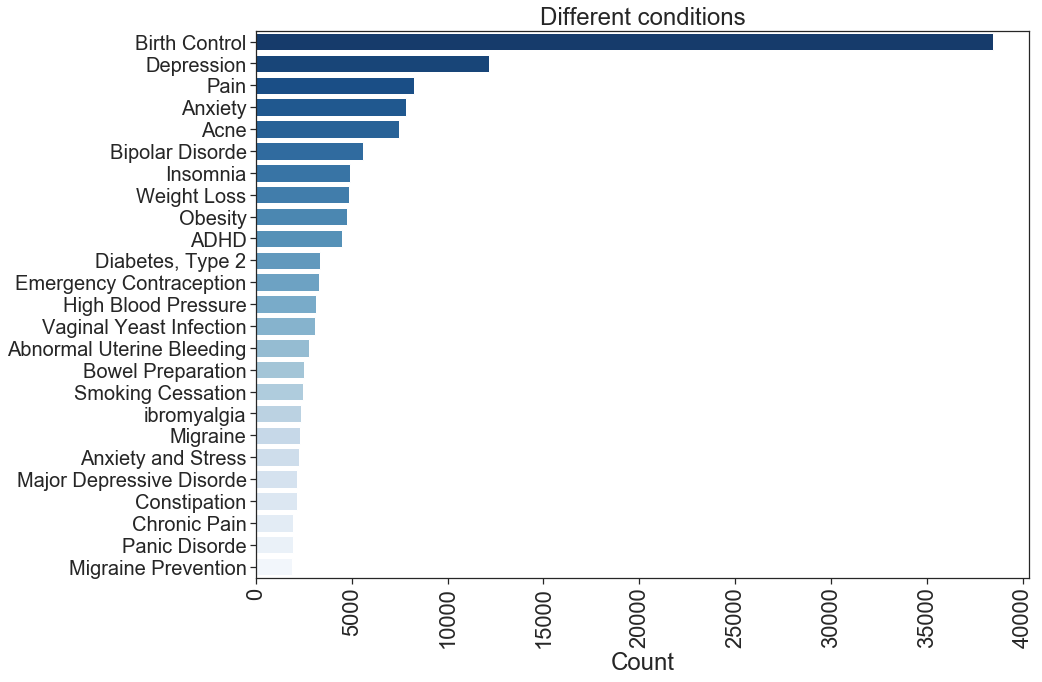

In [13]:
# Plotting of number of unique conditions in the data set
condition = drugs.condition.value_counts().reset_index().rename(columns={'index': 'condition', 'condition': 'Frequency'})
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.set_style("darkgrid")
sns.set_style("ticks")
sns.barplot(y="condition", x="Frequency", data=condition.iloc[0:25], palette= 'Blues_r')
plt.title('Different conditions')
plt.ylabel('', fontsize=20)
plt.xlabel('Count')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 20)
plt.tight_layout()
plt.savefig('Conditions in data.png')
;

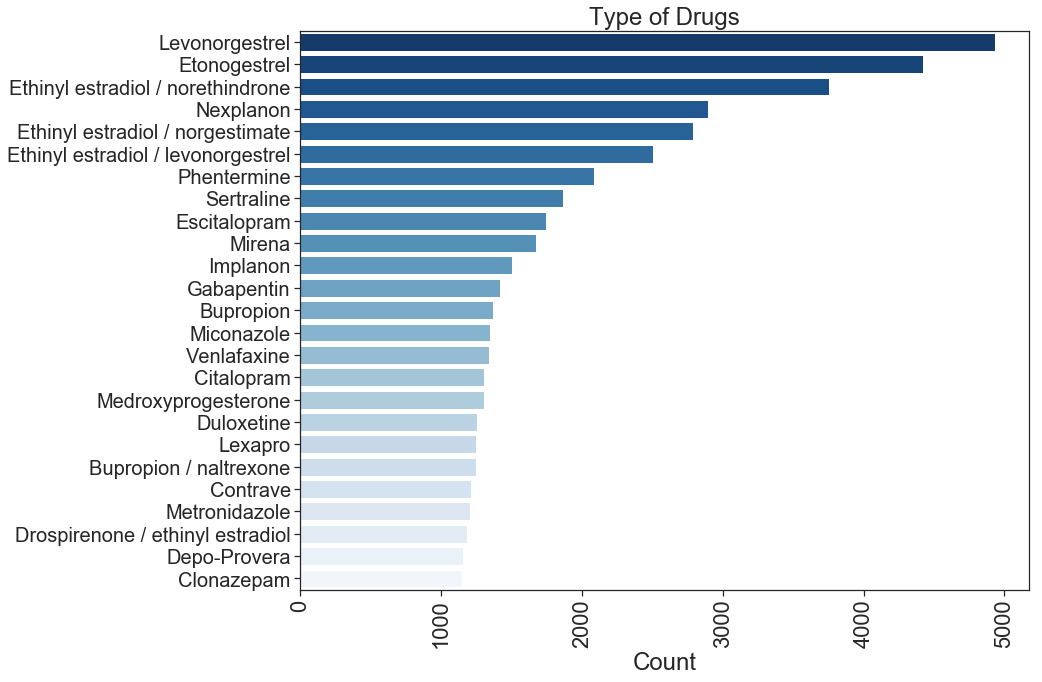

In [14]:
# Plotting of number of unique drugs in the data set

drug = drugs.drugName.value_counts().reset_index().rename(columns={'index': 'Drug', 'drugName': 'Frequency'})
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.set_style("darkgrid")
sns.set_style("ticks")
sns.barplot(y="Drug", x="Frequency", data=drug.iloc[0:25], palette= 'Blues_r')
plt.title('Type of Drugs')
plt.ylabel('', fontsize=20)
plt.xlabel('Count')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 20)
plt.tight_layout()
plt.savefig('drugs in data.png');

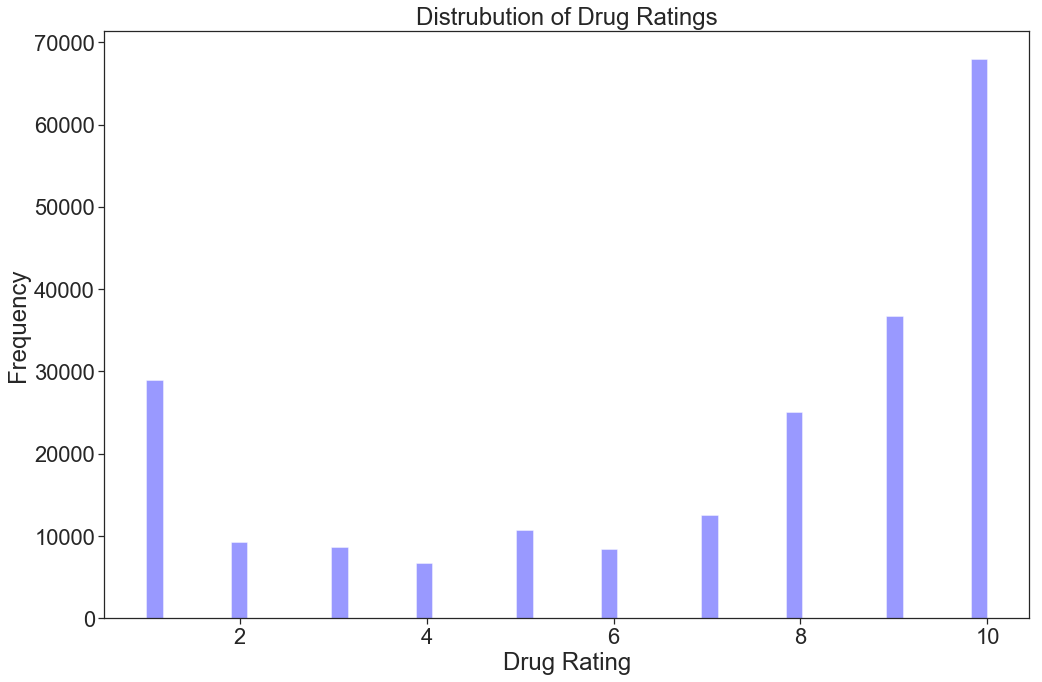

In [15]:
# Plotting of number of indidivual ratings in the data set
drugs.rating.value_counts()
sns.distplot(drugs.rating, color = 'blue', kde= False)
sns.set_style("ticks")
plt.title('Distrubution of Drug Ratings')
plt.xlabel('Drug Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('Rating Distribution in Drugs');

In [16]:
# some exploratory data analysis looking at top condition in the data.
drugs[drugs.condition == 'Birth Control'].count()

UniqueID       38436
drugName       38436
condition      38436
review         38436
rating         38436
date           38436
usefulCount    38436
dtype: int64

In [17]:
# some exploratory data analysis looking at top drug name in the data.
drugs[drugs.drugName == 'Levonorgestrel'].count()

UniqueID       4930
drugName       4930
condition      4896
review         4930
rating         4930
date           4930
usefulCount    4930
dtype: int64

In [18]:
# explore the review at index 2
drugs.review[2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

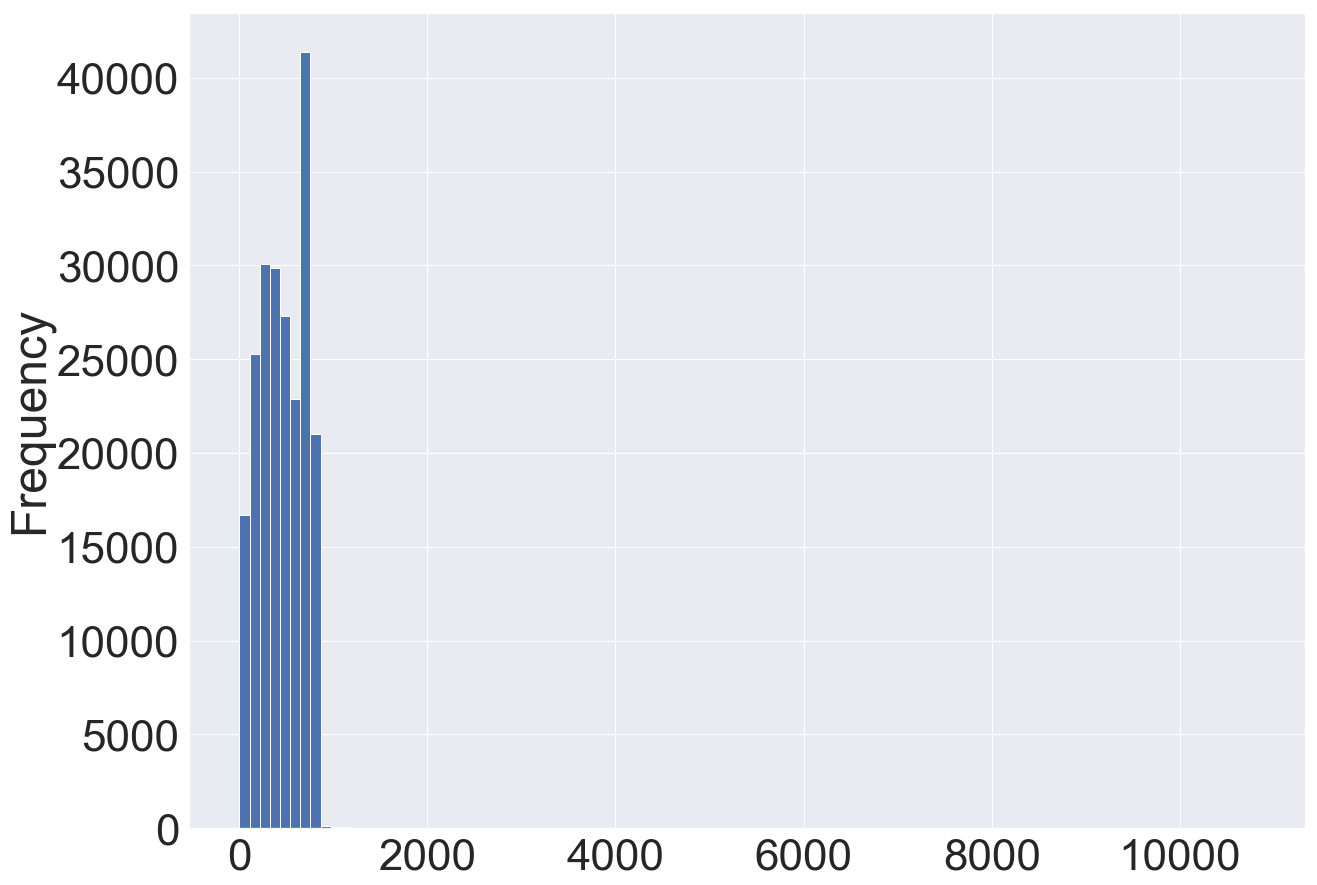

In [21]:
# get the  review length of the reviews and plot the review lenght in the entire data set

drugs['character_length'] = drugs['review'].apply(len)
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
drugs['character_length'].plot(bins=100, kind='hist'); 

In [22]:
drugs.head()

UniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...     9.0 2012-05-20   
1  "My son is halfway through his fourth week of ...     8.0 2010-04-27   
2  "I used to take another oral contraceptive, wh...     5.0 2009-12-14   
3  "This is my first time using any form of birth...     8.0 2015-11-03   
4  "Suboxone has completely turned my life around...     9.0 2016-11-27   

   usefulCount  character_length  
0           27                79  
1          192               741  
2           17               755  
3           10               448  
4           37               719

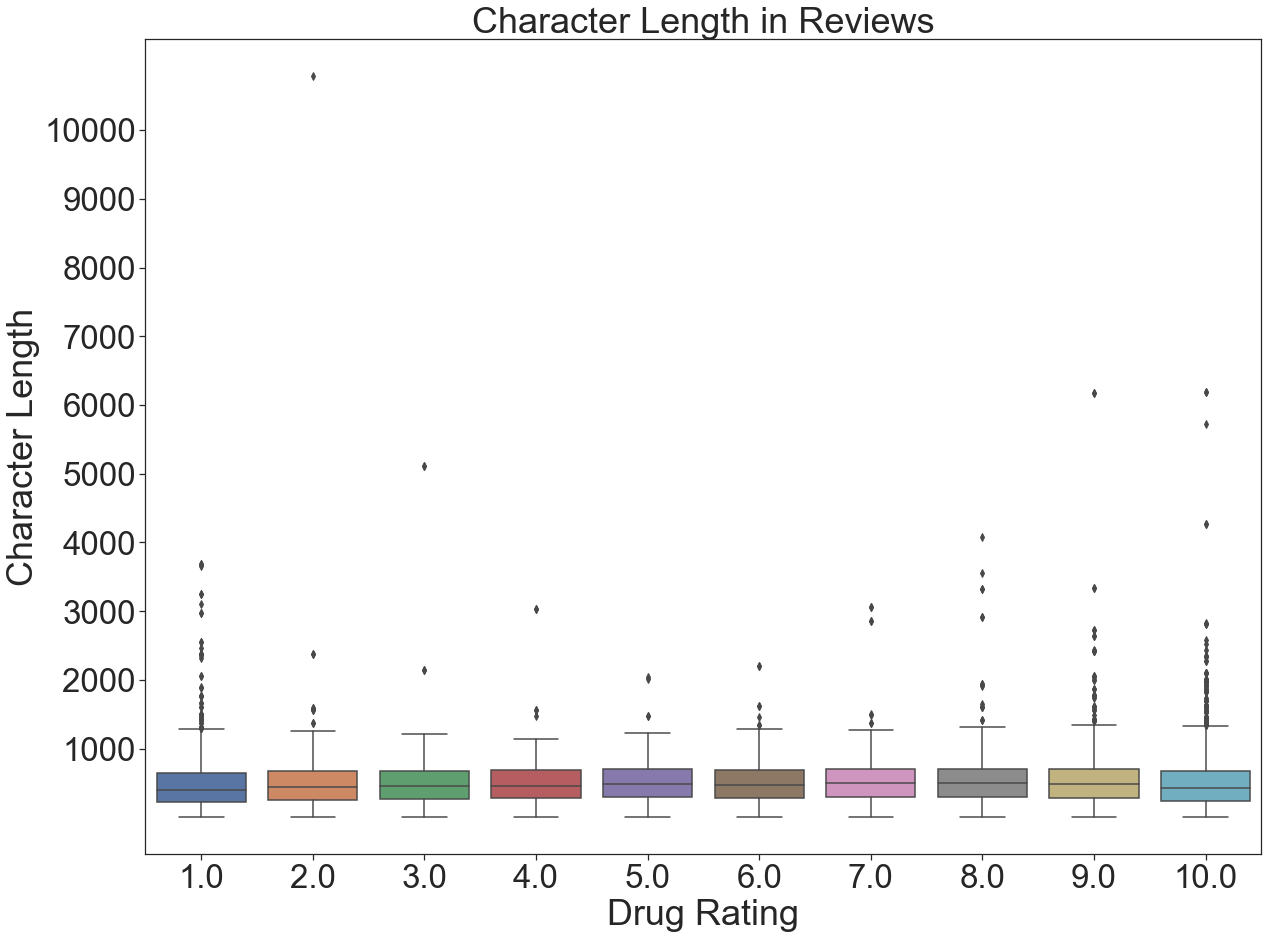

In [23]:
# plot box plot for character lenght. Looks like there are outliers in each rating

sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=3)
sns.set_style("ticks")
sns.boxplot(x='rating', y='character_length', data=drugs)

plt.yticks(list(range(10000, 0, -1000)))
plt.title('Character Length in Reviews')
plt.xlabel('Drug Rating')           
plt.ylabel('Character Length');

plt.savefig('character length of reviews.png');

In [24]:
# Plotting individual ratings and character lenght in each rating
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=15)
g = sns.FacetGrid(data=drugs, col='rating', height=50, aspect=1, col_wrap=3)
g.map(plt.hist, 'character_length', bins=30,  color="r")
plt.xlabel('Character Length');

In [25]:
# Check the stats for the character lenght
drugs.character_length.describe()

count    215063.000000
mean        458.620748
std         240.995226
min           3.000000
25%         262.000000
50%         456.000000
75%         690.000000
max       10787.000000
Name: character_length, dtype: float64

In [28]:
# top character text from the data. 10787 is the character length. Almost 4 pages.

drugs[drugs['character_length'] ==10787]['review'].iloc[0]

'"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conversational vo

In [29]:
# Word count in the review in the data
drugs['word_count'] = drugs['review'].apply(lambda x: len(str(x).split(" ")))
drugs.head()

UniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...     9.0 2012-05-20   
1  "My son is halfway through his fourth week of ...     8.0 2010-04-27   
2  "I used to take another oral contraceptive, wh...     5.0 2009-12-14   
3  "This is my first time using any form of birth...     8.0 2015-11-03   
4  "Suboxone has completely turned my life around...     9.0 2016-11-27   

   usefulCount  character_length  word_count  
0           27                79          17  
1          192               741         141  
2           17               755         133  
3           10               448          89  
4           37               719         134

In [30]:
# total word count in all of the review columns
drugs["review"].str.split().str.len().sum()

18212014

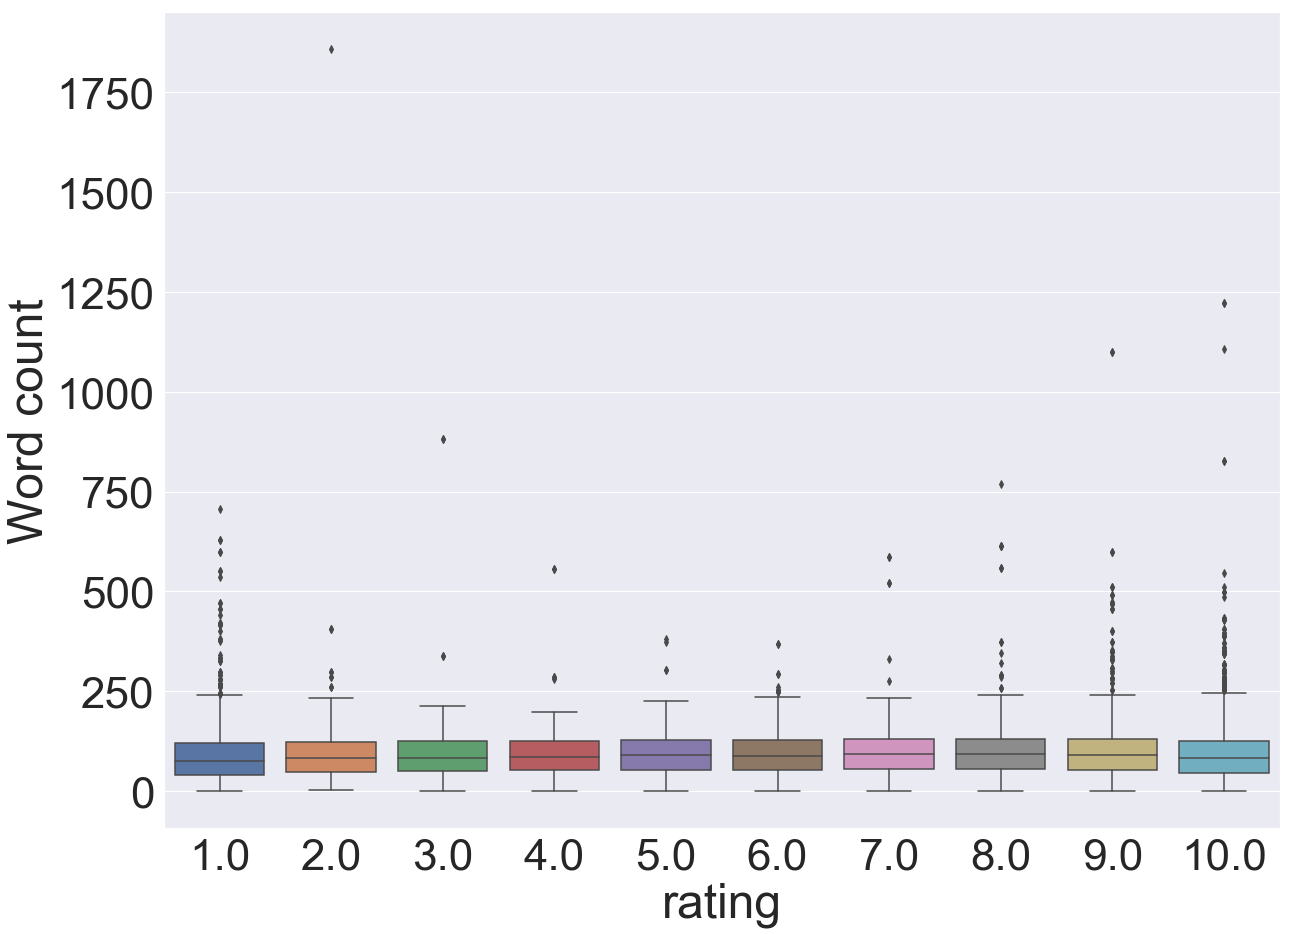

In [31]:
# plot word count as box plot to see the outliers. 
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='word_count', data=drugs)
plt.ylabel('Word count');

In [32]:
# stats for word count
drugs.word_count.describe()

count    215063.000000
mean         85.632029
std          45.323405
min           1.000000
25%          49.000000
50%          85.000000
75%         127.000000
max        1857.000000
Name: word_count, dtype: float64

In [33]:
# Explore single words
drugs[drugs['word_count'] ==1]['review'].head()

371      "Headache"
1090        "Great"
1914      "Awesome"
2097    "expensive"
2193         "Good"
Name: review, dtype: object

In [34]:
# top 25 frequent words in the text
freq_drugs_top = pd.Series(' '.join(drugs['review']).split()).value_counts()[:25]
print(freq_drugs_top)

I       883057
and     563694
the     484954
to      425525
a       376651
my      330282
it      266069
for     260027
was     229373
of      226444
have    223421
on      173244
in      156598
is      147266
had     146513
but     144612
this    136890
with    134673
that    126769
me      119671
been    102493
not     100349
"I       91674
so       89331
at       78326
dtype: int64


In [35]:
# bottom 25 frequent words in the text 
freq_drugs_bottom = pd.Series(' '.join(drugs['review']).split()).value_counts()[-25:]
print(freq_drugs_bottom)

12/3/15.                 1
crapper                  1
softener/laxative.       1
smpathy.                 1
vengeance!!"             1
MONEY!!!                 1
neck/back.               1
75"                      1
lay/sit                  1
(sneezing                1
Hummus                   1
156lbs.                  1
ultra-sound              1
God--                    1
resolves!"               1
sis&#039;s               1
years!....               1
,180-300                 1
question"                1
shaking/blushing/lump    1
ABOUT!                   1
year...my                1
smaller/lighter          1
that...no                1
spasms..The              1
dtype: int64


In [36]:
# stop words 
stop = set(stopwords.words("english"))
#stop.update(("mg","day", 'month', 'wa','first','time', 'took','week', 'year', 'phentermine', 'adipex', 'belviq', 'contrave'))

In [40]:

# clean the text using below for loop
clean_text = []
for index in range(len(drugs)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', drugs['review'][index])

    #Convert to lowercase
    text = text.lower()
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()

    text = " ".join(text)
    clean_text.append(text)
    
drugs['clean_text'] = clean_text

In [41]:
# check if the cleaning of text went well. 
drugs.head()

UniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...     9.0 2012-05-20   
1  "My son is halfway through his fourth week of ...     8.0 2010-04-27   
2  "I used to take another oral contraceptive, wh...     5.0 2009-12-14   
3  "This is my first time using any form of birth...     8.0 2015-11-03   
4  "Suboxone has completely turned my life around...     9.0 2016-11-27   

   usefulCount  character_length  word_count  \
0           27                79          17   
1          192               741         141   
2           17               755         133   
3           10               448          89   
4           37               719         134   

                                          clean_text  
0  it has no side effect i take it in combination...  
1  my son is halfway through his fourth week of i...  
2  i used to take another oral contraceptive whic...  
3  this is my first time using any form of birth ...  
4  suboxone has completely turned my life around ...

In [42]:
# Spelling correction 
drugs['clean_text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: clean_text, dtype: object

In [43]:
# making sure everything is working well with clea_text

rating_10 = drugs.loc[(drugs.rating == 10)].reset_index()
rating_1 = drugs.loc[(drugs.rating == 1)].reset_index()


In [44]:
# just checking text for rating 10 at index position 40
rating_10['clean_text'][40]

'i just want to say that after taking a lot of other anti depressant meds this is the one besides only having side effect diarrhea that went away after wks it s really changed my life i recommend this to anyone who has tried other meds that have not worked'

In [45]:
# just checking text for rating 1 at index position 1000
rating_1['clean_text'][1000]

'my blood sugar s were constantly in the to range i experienced a burning sensation in my stomach and stomach pain and discomfort constantly i had extreme thirst my fluid intake doubled i was drinking approximately to gallons of fluid a day with frequent urination finally my stomach discomfort reached such a high level that i had to stop taking the medication my blood sugar s were still in the upper and lower range as well so i thought thw medicatio was ineffective as well and as my side effects were no longer tolerable'

In [46]:
# downloaded png image for free to be used as a mask for word cloud. This has the same of medicine capsule
capsule = np.array(Image.open("Download-Capsule-PNG-Images.png"))

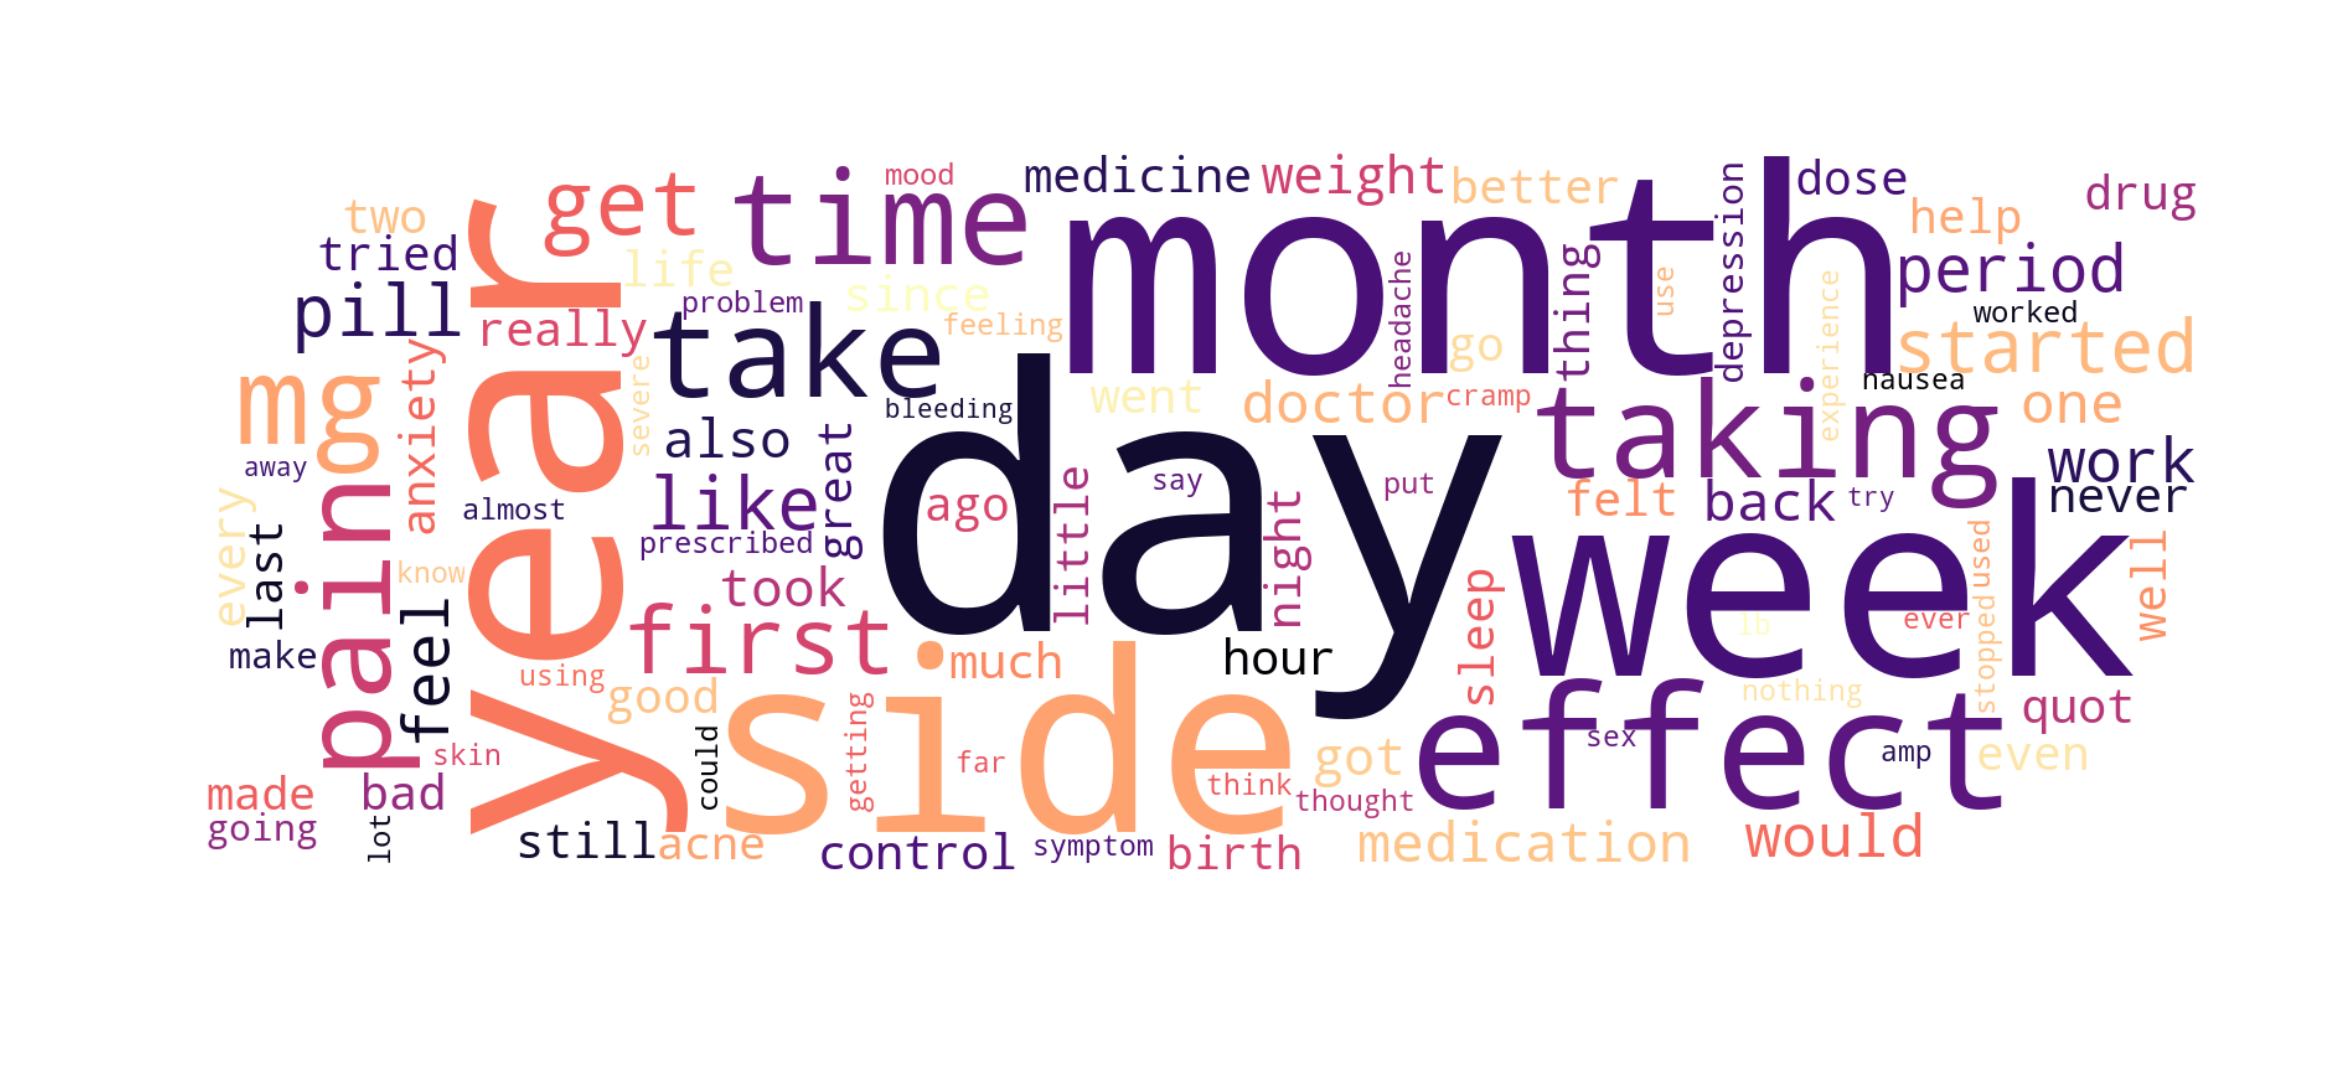

In [47]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma, mask = capsule,
                          stopwords=stop,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("word2.png")
plt.show()



             Bigram         Freq
0      side effects  2358.546073
1         have been  1824.746853
2            for me  1751.598099
3            it was  1565.793703
4            in the  1538.592449
5           been on  1521.706268
6            and it  1451.442394
7         the first  1414.217277
8            of the  1413.970918
9             in my  1306.240566
10         and have  1241.208101
11            it is  1230.645097
12           to the  1221.052611
13          for the  1208.827217
14          ve been  1199.212731
15  this medication  1163.607799
16           on the  1162.056665
17    birth control  1101.277450
18        my doctor  1075.431793
19        my period  1071.041877
20          my life  1066.244614
21           and my  1048.466774
22    this medicine  1041.386927
23            to be  1032.362184
24         have had  1026.720981
25         the only  1011.156428
26            of my  1004.576324
27           it has   999.055475
28        for about   997.618214
29        

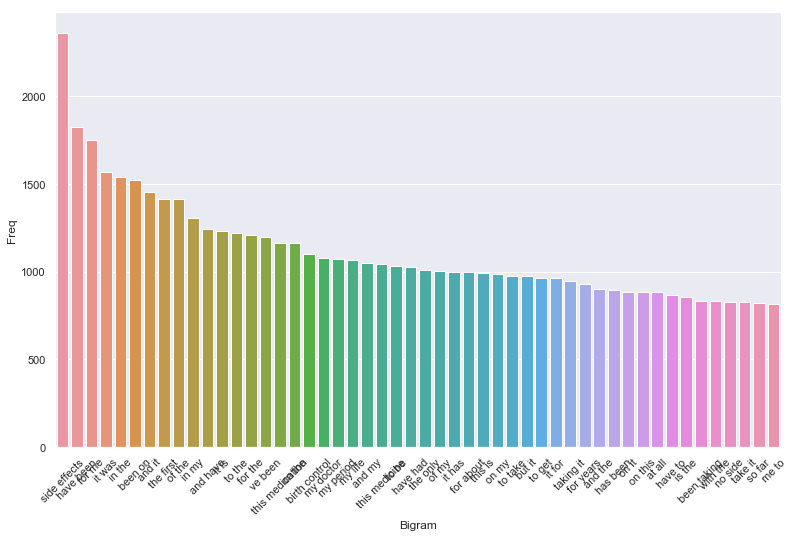

In [48]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 5).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

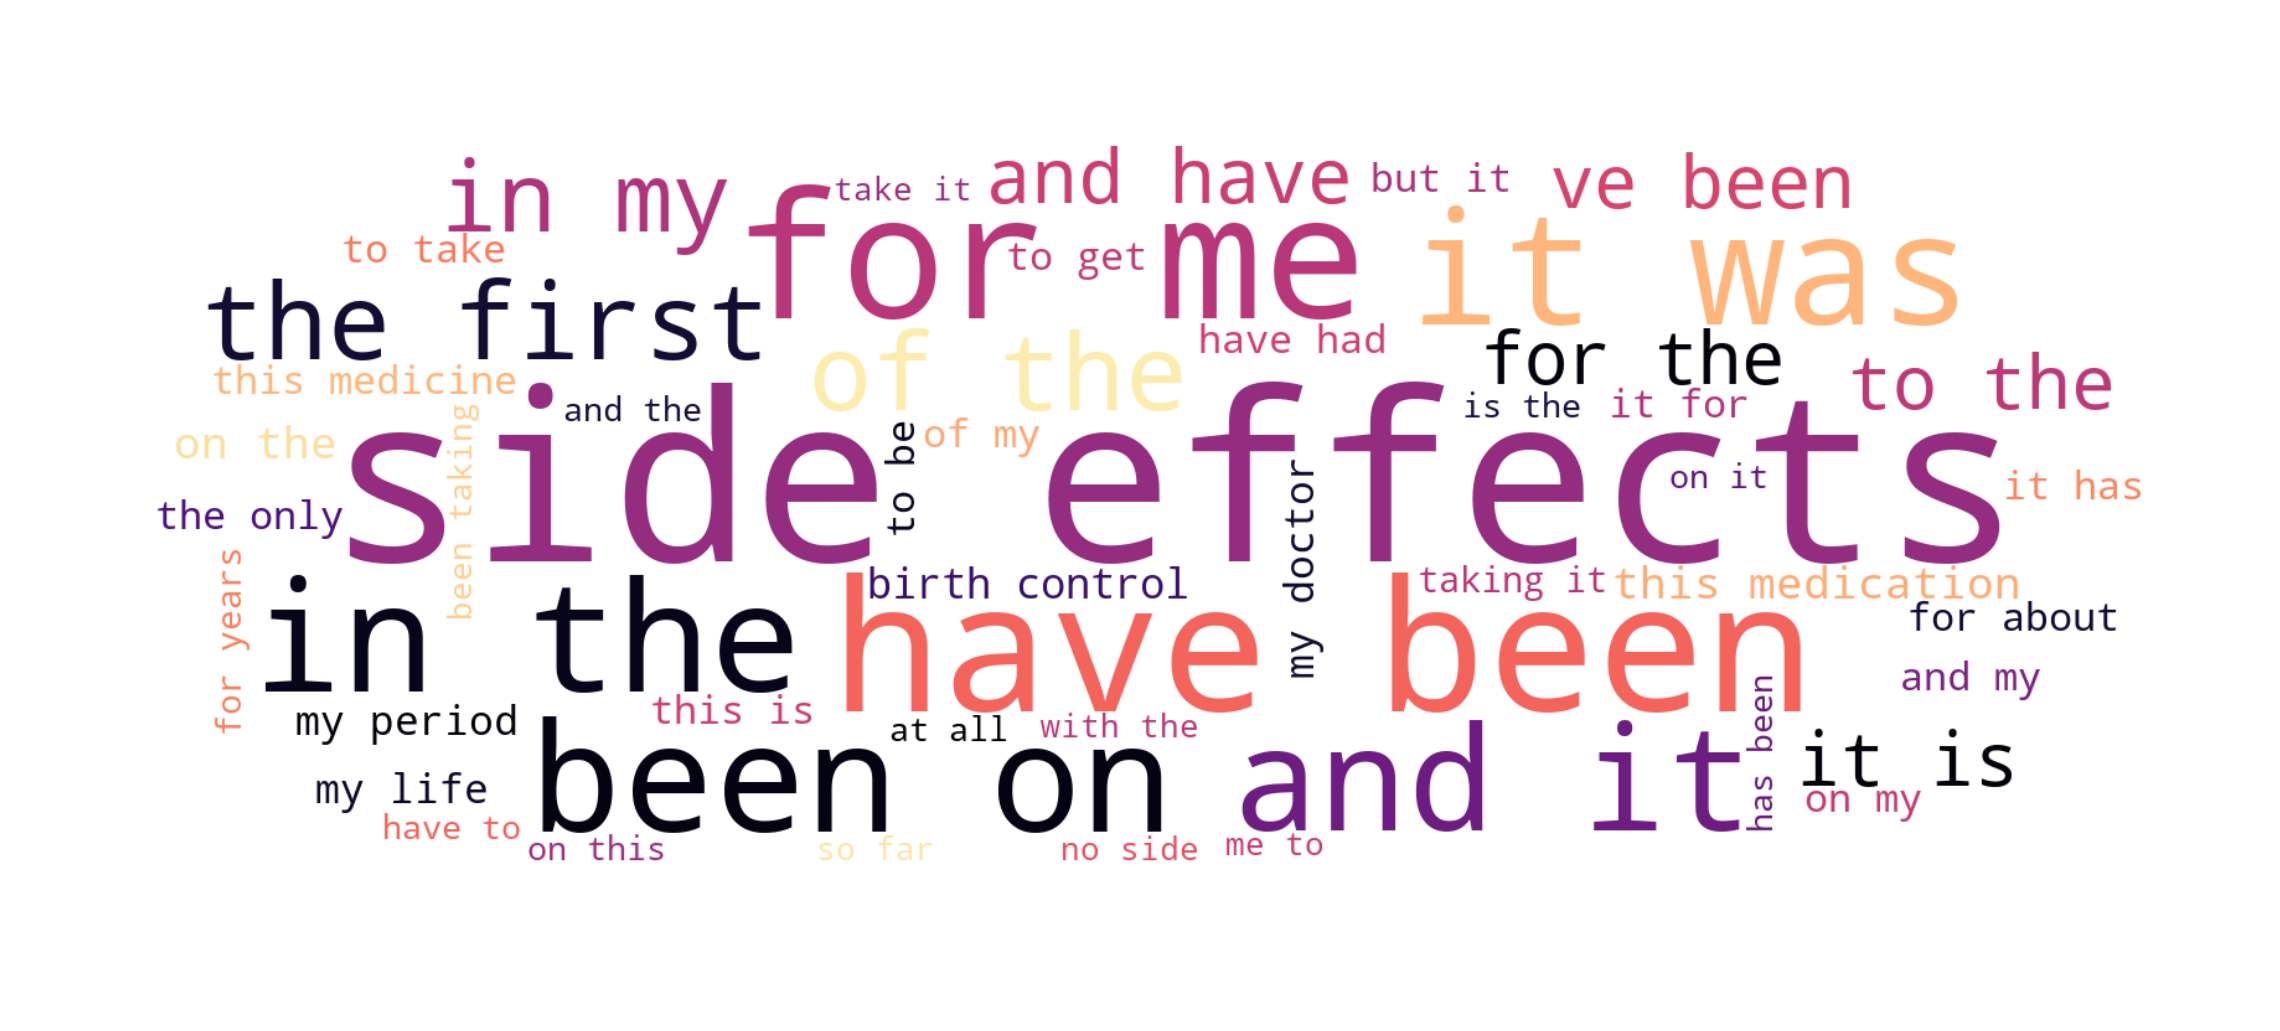

In [49]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                     min_word_length =2, relative_scaling=1, mask = capsule, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

               Trigram        Freq
0         have been on  863.465798
1      no side effects  825.725554
2     the side effects  749.324060
3           ve been on  658.501745
4     have been taking  520.550732
5        for the first  458.224213
6       in the morning  442.820813
7         all the time  409.158270
8          this is the  385.582642
9   this birth control  382.393728
10        been on this  379.520715
11           on it for  377.832523
12          been on it  374.620496
13           put me on  358.157235
14      the first time  356.449456
15         it has been  331.250997
16       and have been  320.376405
17      ve been taking  314.064033
18          to take it  312.449598
19         is the only  307.230015
20    for about months  302.569848
21    any side effects  299.304745
22          it made me  288.097173
23      the only thing  286.353415
24       for years and  284.342973


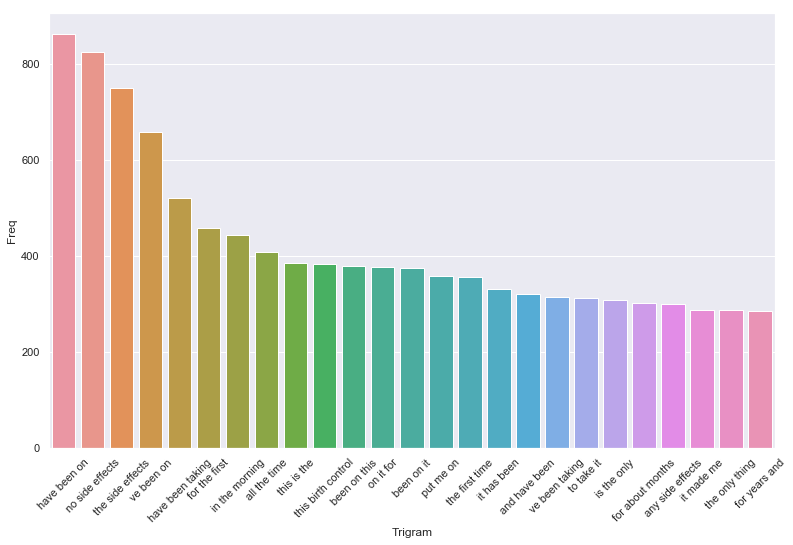

In [50]:
#Most frequently occuring trigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_tri_grams(clean_text, n=None):
    vectorizer = TfidfVectorizer(ngram_range = (3,3), min_df = 5).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_trigrams = top_tri_grams(clean_text, n=25)
top_trigrams_df = pd.DataFrame(top_trigrams)
top_trigrams_df.columns=["Trigram", "Freq"]
print(top_trigrams_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Trigram", y="Freq", data=top_trigrams_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45);

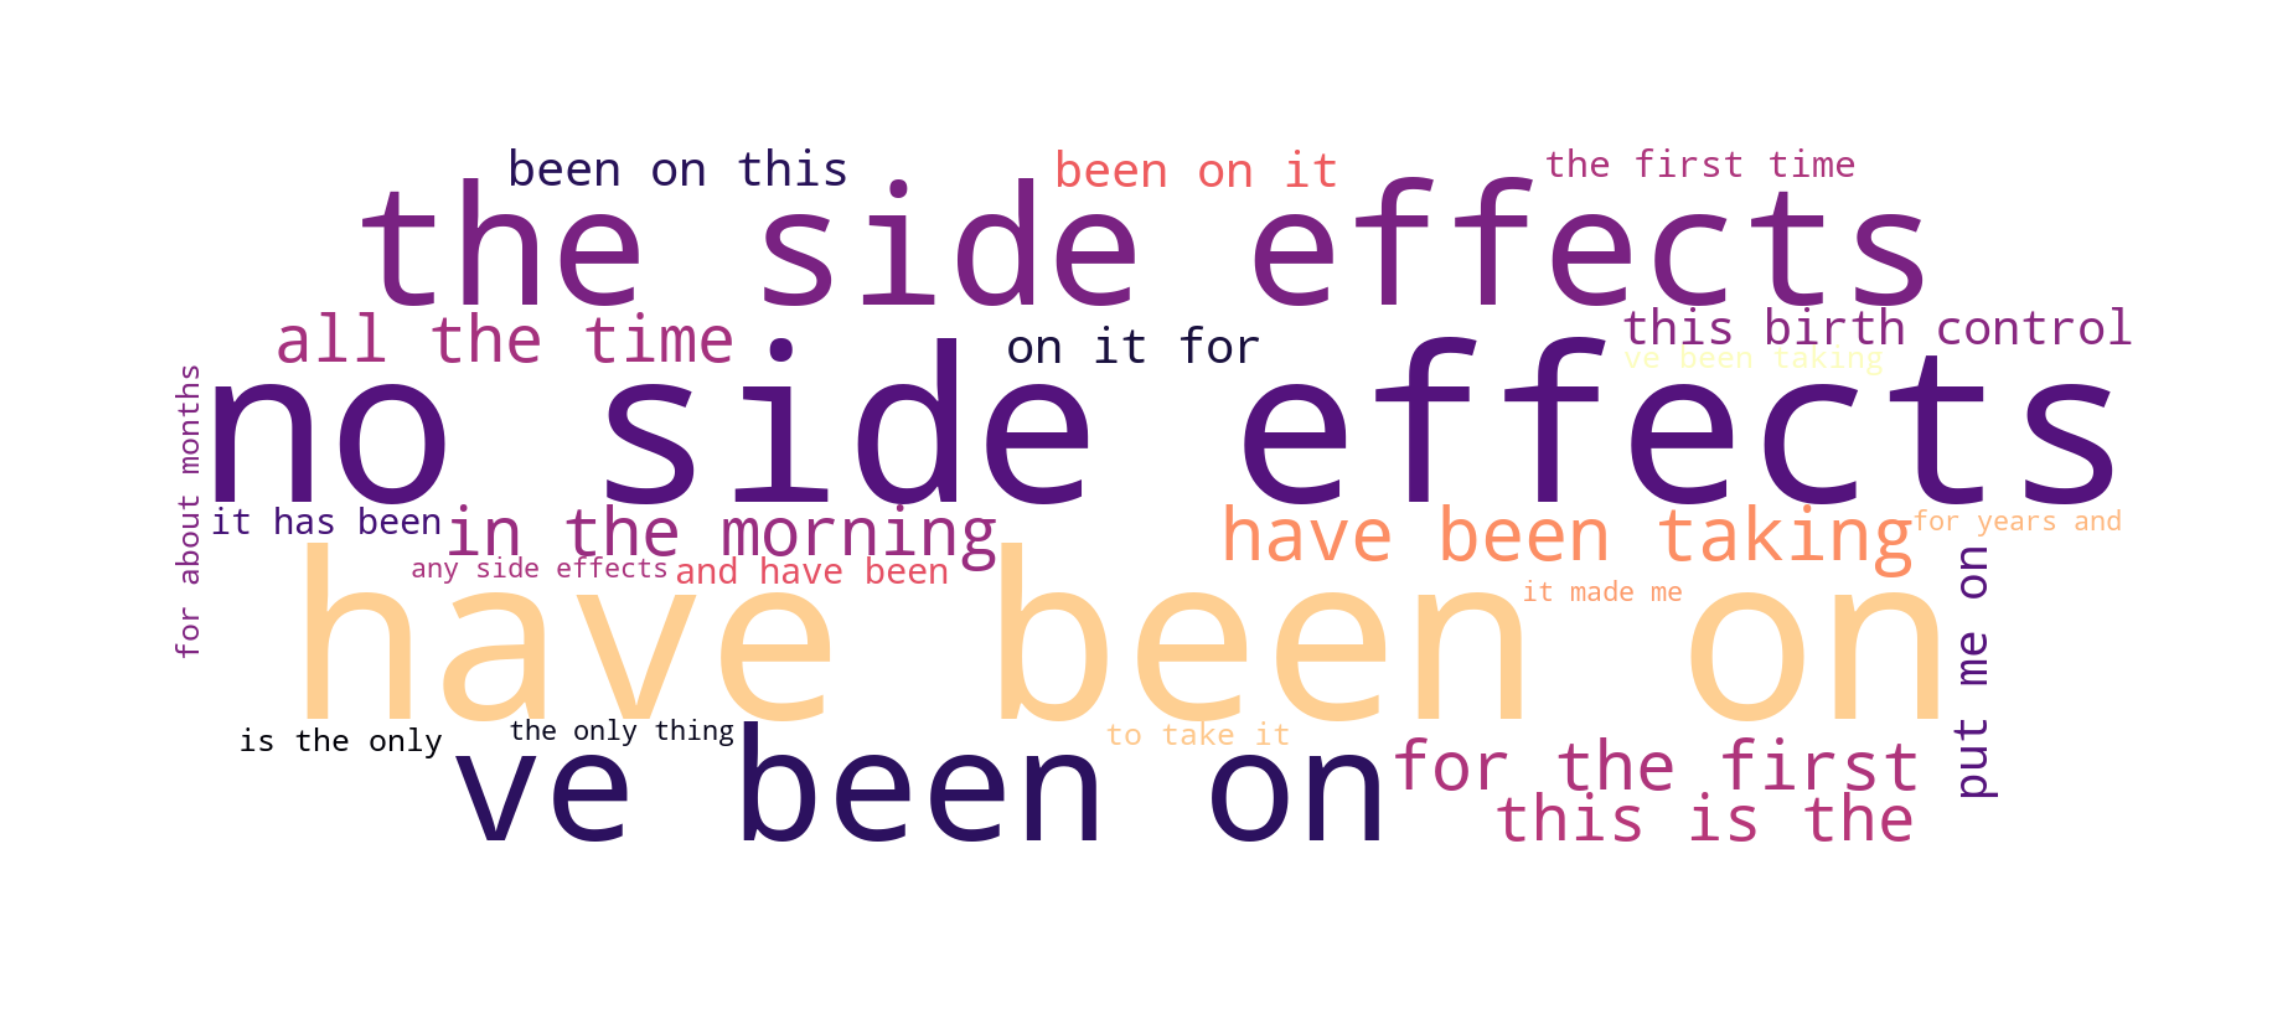

In [51]:
trigrams = {}
for w, x in top_trigrams_df.values:
    trigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white', mask = capsule,colormap=plt.cm.magma,collocations=False).generate_from_frequencies(trigrams)

plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [52]:
# Defining the rating into three classes. For this project I kept the same rating as original published manuscript.Other ways 
# may be to use vadersentiment analysis and comeup with classification strategy

def classifier(row):
    
    if row["rating"] >= 7.0:
        return 'positive'
    elif row["rating"] <= 4.0:
        return 'negative'
    else:
        return 'neutral'


In [53]:
# also classified into binary classfication just incase we can use it later
def classifier2(row):
    
    if row["rating"] >= 7.0:
        return 2
    elif row["rating"] <= 4.0:
        return 0
    else:
        return 1

In [54]:
# applying the classified functions into the ratings an creating a new columns for both classifiers

drugs['rating_class'] = drugs.apply(classifier, axis=1)
drugs['rating_class_numeric'] = drugs.apply(classifier2, axis=1)

In [55]:
# check how the classes are classified with value counts. 
drugs['rating_class'].value_counts()

positive    142306
negative     53572
neutral      19185
Name: rating_class, dtype: int64

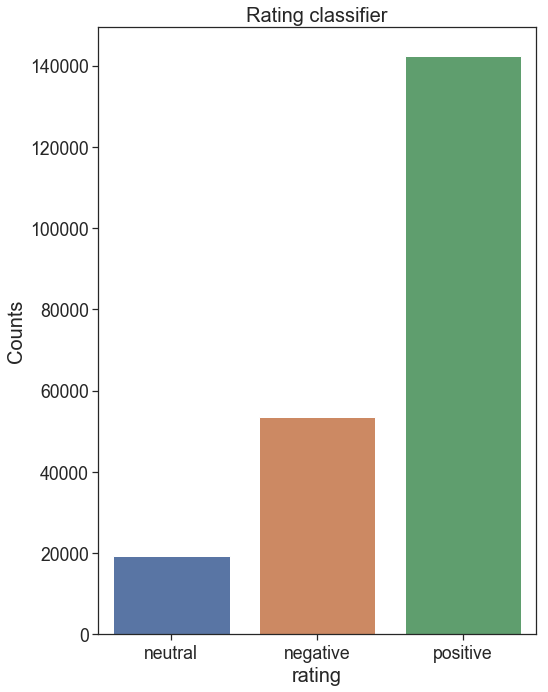

In [58]:
# plot the classifiers to visualize the class imbalance. 
sns.set(rc={'figure.figsize':(8,10)}, font_scale=1.6)
sns.set_style("ticks")
partial = drugs['rating_class'].value_counts(ascending=True, sort=True)
sns.barplot(partial.index, partial.values, alpha=1)
plt.title('Rating classifier', fontsize = 20)
plt.ylabel('Counts', fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.yticks()
plt.tight_layout()
plt.savefig('Imbalanced Class.png')
plt.show()



In [61]:
# uncomment to save the final csv file to be used for models 
#drugs.to_csv('drugs_model.csv', index=False)
   